In [3]:
import pymc3 as pm
import arviz as az
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from theano import shared 
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [4]:
def r2(y_hat, y):
    e = (y_hat - y)
    var_e = np.mean((e - np.mean(e))**2)
    var_y = np.mean((y - np.mean(y))**2)
    r2 = 1 - (var_e / var_y)
    return r2

In [5]:
brains = pd.DataFrame.from_dict(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


[]

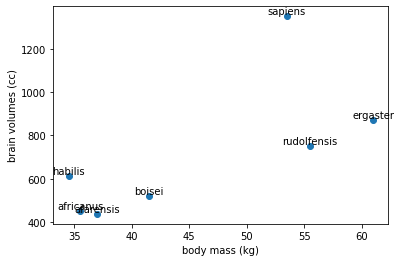

In [6]:
plt.scatter(brains.mass, brains.brain)
plt.xlabel("body mass (kg)")
plt.ylabel("brain volumes (cc)")
for index,row in brains.iterrows():
    plt.text(row.mass, row.brain, row.species, ha = "center", va = "bottom")
plt.plot()

In [7]:
# standardize
brains["mass_std"] = (brains["mass"] - brains["mass"].mean()) / brains["mass"].std()
brains["brain_std"] = brains["brain"] / np.max(brains["brain"])

In [8]:
# linear model
# vague priors we will use frequentist regression 
m7_1 = smf.ols("brain_std ~ mass_std", data=brains).fit()
m7_1.summary()

/home/schubertj/.local/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Mon, 28 Dec 2020   Prob (F-statistic):             0.0798
Time:                        16:56:54   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1671      0.076      2.192      0.080      -0.029       0.363
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# second degree polynomial
m7_2 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2)", data=brains).fit()

# third degree polynomial
m7_3 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3)", data=brains).fit()

# fourth degree polynomial
m7_4 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4)", data=brains).fit()

# fifth degree polynomial
m7_5 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4) + I(mass_std ** 5)", data=brains).fit()

# six degree polynomial
m7_6 = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4) + I(mass_std ** 5) + I(mass_std ** 6)", data=brains).fit()

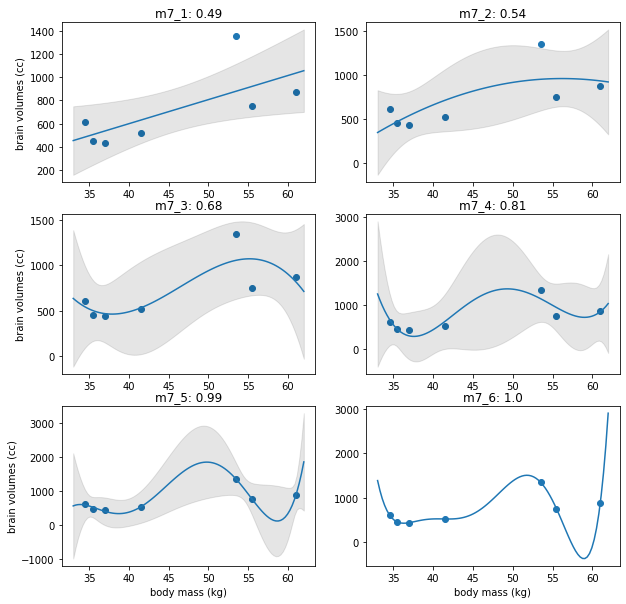

In [27]:
fig, axs = plt.subplots(3,2, figsize = (10, 10))

mass_plot = np.linspace(33, 62, 100)
mass_new = (mass_plot - brains.mass.mean()) / brains.mass.std()

models = [m7_1, m7_2, m7_3, m7_4, m7_5, m7_6]
names = ["m7_1", "m7_2", "m7_3", "m7_4", "m7_5", "m7_6"]

for model, name, ax in zip(models, names, axs.flat):
    prediction = model.get_prediction({"mass_std": mass_new})
    pred = prediction.summary_frame(alpha = 0.11) * brains.brain.max()
    
    ax.plot(mass_plot, pred["mean"])
    ax.scatter(brains.mass, brains.brain)
    ax.fill_between(mass_plot, pred["mean_ci_lower"], pred["mean_ci_upper"], alpha = 0.1, color = "black")
    ax.set_title("{}: {}".format(name, np.round(model.rsquared, 2)))
    if ax.is_last_row():
        ax.set_xlabel("body mass (kg)")
    if ax.is_first_col():
        ax.set_ylabel("brain volumes (cc)")

In [ ]:
m7_1.predict

In [33]:
m7_1.

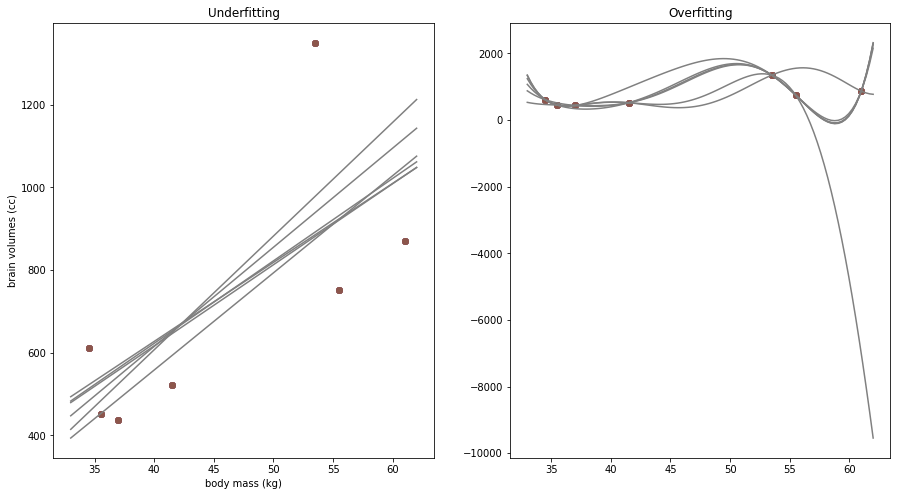

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
# Figure 7.4
for i in range(brains.shape[0] - 1):
    dat = brains.drop(i, axis=0)
    m_linear = smf.ols("brain_std ~ mass_std", data=dat).fit()
    
    m_linear_pred = m_linear.get_prediction({"mass_std": mass_new})
    m_linear_pred = m_linear_pred.summary_frame() * brains.brain.max()
    
    m_poly = smf.ols("brain_std ~ mass_std + I(mass_std ** 2) + I(mass_std ** 3) + I(mass_std ** 4) + I(mass_std ** 5) + I(mass_std ** 6)", data=dat).fit()
    m_poly_pred = m_poly.get_prediction({"mass_std": mass_new})
    m_poly_pred = m_poly_pred.summary_frame() * brains.brain.max()

    ax[0].scatter(brains.mass, brains.brain)
    ax[0].plot(mass_plot, m_linear_pred["mean"], color = "grey")
    ax[0].set_xlabel("body mass (kg)")
    ax[0].set_ylabel("brain volumes (cc)")
    ax[0].set_title("Underfitting")

    ax[1].scatter(brains.mass, brains.brain)
    ax[1].plot(mass_plot, m_poly_pred["mean"], color = "grey")
    ax[1].set_title("Overfitting")

We want to simulate the following model

$y_i \sim Normal(\mu_i, 1)$

$\mu_i = 0.15x_{1,i} -0.4x_{2,i}$ 

In [15]:
def m_sim():
    x1 = stats.norm.rvs(size=100)
    x2 = stats.norm.rvs(size=100)
    mu = 0.15*x1 -0.4*x2
    y = stats.norm.rvs(mu, 1, size=100)
    return y

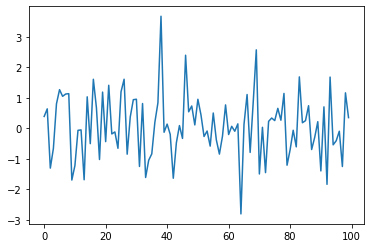

In [17]:
#define 5 models

with pm.Model() as m1:
    sigma = pm.Exponential(1)
    bX1= pm.Normal("bX1", 0, 1)
    mu = bX1*x1
    ll = pm.Normal("ll", mu, sigma, observed=y)
    m1_trace = pm.sample()
 
 with pm.Model() as m1:
    sigma = pm.Exponential(1)
    bX1= pm.Normal("bX1", 0, 1)
    mu = bX1*x1
    ll = pm.Normal("ll", mu, sigma, observed=y)
    m1_trace = pm.sample()

### Cross-validation